In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


Shuffling and writing examples to /home/mateusz/tensorflow_datasets/oxford_iiit_pet/3.0.0.incompleteSV8GIJ/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /home/mateusz/tensorflow_datasets/oxford_iiit_pet/3.0.0.incompleteSV8GIJ/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /home/mateusz/tensorflow_datasets/oxford_iiit_pet/3.0.0. Subsequent calls will reuse this data.


In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)


In [7]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()


In [13]:
OUTPUT_CHANNELS = 3


In [10]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False


9412608/9406464 [==============================] - 27s 3us/step


In [11]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]
def unet_model(output_channels):

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [14]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [17]:
tf.keras.utils.plot_model(model, show_shapes=True)


Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


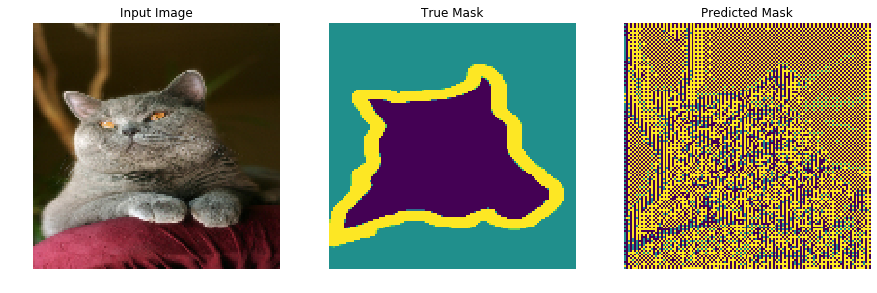

In [20]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions()

In [21]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


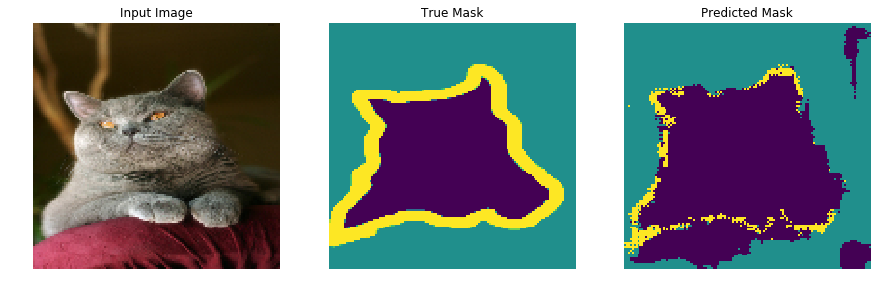


Sample Prediction after epoch 2

 3/57 [>.............................] - ETA: 11:13 - loss: 0.3402 - accuracy: 0.8632

KeyboardInterrupt: 

In [22]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])
